In [ ]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# For embeddings and similarity computation 
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)

Required libraries imported successfully!


In [157]:
from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML

# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

In [158]:
import json
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple

def load_corpus(file_path: str) -> Dict[str, Dict]:
    """
    Charge les données du corpus à partir d'un fichier JSONL.
    Retourne un dictionnaire mappant les IDs de document aux données de document.
    """
    corpus = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            doc = json.loads(line)
            corpus[doc['_id']] = doc
    return corpus

def load_queries(file_path: str) -> Dict[str, Dict]:
    """
    Charge les données de requête à partir d'un fichier JSONL.
    Retourne un dictionnaire mappant les IDs de requête aux données de requête.
    """
    queries = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            query = json.loads(line)
            queries[query['_id']] = query
    return queries

def load_qrels(file_path: str) -> Dict[str, Dict[str, int]]:
    """
    Charge les jugements de pertinence (qrels) à partir d'un fichier TSV.
    Retourne un dictionnaire mappant les IDs de requête aux scores de pertinence
    des candidats (1 pour pertinent, 0 pour non-pertinent).
    """
    qrels = defaultdict(dict)
    df = pd.read_csv(file_path, sep='\t', header=0)
    for _, row in df.iterrows():
        qrels[str(row['query-id'])][str(row['corpus-id'])] = int(row['score'])
    return dict(qrels) 

# Load the dataset
corpus = load_corpus('data/corpus.jsonl')
queries = load_queries('data/queries.jsonl')
qrels_valid = load_qrels('data/valid.tsv')


print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries (dataset)")

Loaded 25657 documents in corpus
Loaded 1000 queries
Loaded relevance for 700 queries (dataset)


In [159]:
from collections import defaultdict, Counter
from scipy.sparse import find, csr_matrix

# Statistiques

# Nombre total de paires (requête, candidat)
total_pairs = sum(len(c) for c in qrels_valid.values())

# Nombre total de documents pertinents (score = 1)
total_relevant = sum(sum(c.values()) for c in qrels_valid.values())

# Nombre total de documents non pertinents (score = 0)
total_non_relevant = total_pairs - total_relevant

# Proportions
prop_relevant = total_relevant / total_pairs
prop_non_relevant = total_non_relevant / total_pairs

print("\nStatistiques des données d'évaluation")
print(f"Taille du corpus : {len(corpus)} articles")
print(f"Nombre de requêtes : {len(queries)} (dans queries.jsonl) - {len(qrels_valid)} (avec évaluation disponible)")
print(f"Nombre total de paires (requête, candidat) : {total_pairs}")
print(f"Proportion de documents pertinents (C+) : {prop_relevant:.2f}")
print(f"Proportion de documents non pertinents (C-) : {prop_non_relevant:.2f}")

# Exemple de requête
query_id = list(qrels_valid.keys())[0] # Prendre la première requête
q_doc = queries.get(query_id) or corpus.get(query_id)

print("\nExemple de Requête")
print(f"Requête ID: {query_id}")
print(f"Titre de la Requête (Q): \"{q_doc['text']}\"")

# Séparer les candidats pertinents (positifs) des non pertinents (négatifs)
positive_candidates = [doc_id for doc_id, score in qrels_valid[query_id].items() if score == 1]
negative_candidates = [doc_id for doc_id, score in qrels_valid[query_id].items() if score == 0]

# Afficher quelques exemples positifs
print("\nExemples Positifs (C+) :")
for i, doc_id in enumerate(positive_candidates[:2]):
    doc = corpus[doc_id]
    print(f"  - ({doc_id}): \"{doc['title']}\"")

# Afficher quelques exemples négatifs
print("\nExemples Négatifs (C-) :")
for i, doc_id in enumerate(negative_candidates[:2]):
    doc = corpus[doc_id]
    print(f"  - ({doc_id}): \"{doc['title']}\"")


Statistiques des données d'évaluation
Taille du corpus : 25657 articles
Nombre de requêtes : 1000 (dans queries.jsonl) - 700 (avec évaluation disponible)
Nombre total de paires (requête, candidat) : 20950
Proportion de documents pertinents (C+) : 0.16
Proportion de documents non pertinents (C-) : 0.84

Exemple de Requête
Requête ID: 40c6b953b5c04b3df4164cd487c4bc00cf0e487d
Titre de la Requête (Q): "A Microfluidically Reconfigurable Dual-Band Slot Antenna With a Frequency Coverage Ratio of 3:1"

Exemples Positifs (C+) :
  - (d59814a5014f220c1bd43fef6393b1250ecdc58b): "A Coplanar Reconfigurable Folded Slot Antenna Without Bias Network for WLAN Applications"
  - (89c1c6c952e1e962677026269c094b8c0a966ee0): "A Low-Profile Third-Order Bandpass Frequency Selective Surface"

Exemples Négatifs (C-) :
  - (58ab158785a0899210369f76025c1e33c19299f5): "Integration of Modular Process Units Into Process Control Systems"
  - (8a5444e350e59f69ddf37121d9ede8a818f54a3d): "Towards a psychographic user mo

In [160]:
from sklearn.feature_extraction.text import CountVectorizer

# 1. Préparer les textes pour la vectorisation
corpus_ids = list(corpus.keys())
corpus_texts = [corpus[doc_id]['text'] for doc_id in corpus_ids]

# 2. Initialiser et entraîner (fit) le vectoriseur
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_texts)

# 3. Récupérer le vocabulaire
features = vectorizer.get_feature_names_out()

print(f"\n### Encodage CountVectorizer sur les titres ###")
print(f"Matrice Documents x Termes (X) de taille : {X.shape}")
print(f"Taille du vocabulaire : {len(features)} mots")


### Encodage CountVectorizer sur les titres ###
Matrice Documents x Termes (X) de taille : (25657, 76983)
Taille du vocabulaire : 76983 mots



Exemple de vecteur de document (top 10 mots) :
Text : "An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks using a new evolutionary learning algorithm is proposed in this paper. This new evolutionary learning algorithm is based on a hybrid of genetic algorithm (GA) and particle swarm optimization (PSO), and is thus called HGAPSO. In HGAPSO, individuals in a new generation are created, not only by crossover and mutation operation as in GA, but also by PSO. The concept of elite strategy is adopted in HGAPSO, where the upper-half of the best-performing individuals in a population are regarded as elites. However, instead of being reproduced directly to the next generation, these elites are first enhanced. The group constituted by the elites is regarded as a swarm, and each elite corresponds to a particle within it. In this regard, the elites are enhanced by PSO, an operation which mimics the maturing phenomenon in nature. These enhanced elites c

,word,value
0,the,13
1,in,10
2,is,10
3,and,8
4,recurrent,8
5,of,7
6,elites,6
7,network,6
8,to,6
9,by,5



Distribution des mots les plus fréquents :


,word,value
0,the,245032
1,of,162441
2,and,137820
3,to,103949
4,in,89747
5,is,56922
6,for,50890
7,that,42063
8,we,40287
9,this,36374


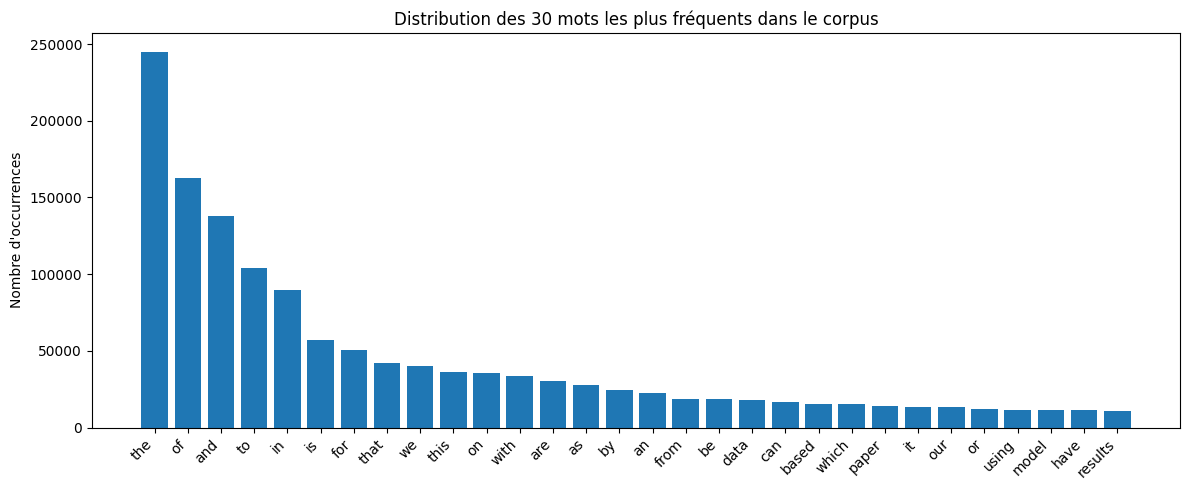

In [161]:
# Afficher des exemples de vecteurs
print("\nExemple de vecteur de document (top 10 mots) :")
doc_index_example = 0 # Le premier document du corpus
v_example = X[doc_index_example]

print(f"Text : \"{corpus_texts[doc_index_example]}\"")
display(print_feats(v_example, features, top_n = 10).style.set_caption("Vecteur du 1er document (CountVectorizer)"))

# Distribution des mots les plus fréquents (dans tout le corpus)
print("\nDistribution des mots les plus fréquents :")

# Calculer la somme des occurrences par colonne (par terme)
term_counts = X.sum(axis=0) 
term_counts_sparse = csr_matrix(term_counts)

# Afficher les 30 mots les plus fréquents
top_terms_df = print_feats(term_counts_sparse, features, top_n=30)
display(top_terms_df.style.set_caption("Top 30 mots les plus fréquents dans les titres"))

# Affichage de l'histogramme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(top_terms_df['word'], top_terms_df['value'])
plt.xticks(rotation=45, ha='right')
plt.title('Distribution des 30 mots les plus fréquents dans le corpus')
plt.ylabel('Nombre d\'occurrences')
plt.tight_layout()
plt.show()

In [162]:
from sklearn.metrics.pairwise import cosine_similarity

print("\n Test de Similarité Cosinus sur Titres (BoW)")

# Choisir une requête et des candidats
query_id_example = list(qrels_valid.keys())[1] 
q_doc_ex = queries.get(query_id_example) or corpus.get(query_id_example)

# Choisir un positif et un négatif
# Utilisation de .index() pour s'assurer que l'ID est dans la liste des IDs du corpus
pos_doc_id = [doc_id for doc_id, score in qrels_valid[query_id_example].items() if score == 1][0]
neg_doc_id = [doc_id for doc_id, score in qrels_valid[query_id_example].items() if score == 0][0]

pos_doc = corpus[pos_doc_id]
neg_doc = corpus[neg_doc_id]

# 1. Encodage des titres (ATTENTION: utiliser .transform(), pas .fit_transform())
titles_to_compare = [q_doc_ex['text'], pos_doc['title'], neg_doc['title']]
X_compare = vectorizer.transform(titles_to_compare)

# X_compare contient [Q, C+, C-]
# 2. Calculer la similarité S(Q, C+) et S(Q, C-)
sim_Q_C_pos = cosine_similarity(X_compare[0], X_compare[1])[0][0]
sim_Q_C_neg = cosine_similarity(X_compare[0], X_compare[2])[0][0]

print(f"\nRequête (Q): \"{q_doc_ex['text']}\"")
print(f"Candidat Positif (C+): \"{pos_doc['title']}\"")
print(f"Candidat Négatif (C-): \"{neg_doc['title']}\"")

print(f"\nScore d'appariement S(Q, C+) : {sim_Q_C_pos:.4f}")
print(f"Score d'appariement S(Q, C-) : {sim_Q_C_neg:.4f}")


 Test de Similarité Cosinus sur Titres (BoW)

Requête (Q): "Development of 50-kV 100-kW Three-Phase Resonant Converter for 95-GHz Gyrotron"
Candidat Positif (C+): "Compact and high repetitive pulsed power modulator based on semiconductor switches"
Candidat Négatif (C-): "A “K Hypotheses + Other” Belief Updating Model"

Score d'appariement S(Q, C+) : 0.0000
Score d'appariement S(Q, C-) : 0.0000


In [163]:
def retrieve_top_k(query_text: str, vectorizer: CountVectorizer, X_corpus: csr_matrix, corpus_ids: List[str], k: int = 10) -> pd.DataFrame:
    """
    Implémente le moteur de recherche basé sur le modèle BoW et la similarité cosinus.
    """
    # Construire le vecteur requête (q)
    q_vec = vectorizer.transform([query_text])

    # Calculer le score S(q, c) pour tous les documents c du corpus
    scores = cosine_similarity(q_vec, X_corpus).flatten()

    # Trier les résultats
    top_k_indices = np.argsort(scores)[::-1][:k]

    # Construire le résultat
    results = []
    for rank, idx in enumerate(top_k_indices):
        doc_id = corpus_ids[idx]
        doc = corpus[doc_id]
        results.append({
            'Rank': rank + 1,
            'Document ID': doc_id,
            'Title': doc['title'],
            'Score S(q, c)': scores[idx]
        })

    return pd.DataFrame(results)

# Tester le moteur
query_id = list(qrels_valid.keys())[0] # Prendre la première requête
q_doc = queries.get(query_id) or corpus.get(query_id)
query_example_text = q_doc['text']

print(f"\nTest du Moteur de Recherche (Approche Creuse - BoW)")
print(f"Requête : \"{query_example_text}\"")

top_results_df = retrieve_top_k(query_example_text, vectorizer, X, corpus_ids, k=7)
display(top_results_df.style.set_caption("Résultats Top 7 (CountVectorizer)"))


Test du Moteur de Recherche (Approche Creuse - BoW)
Requête : "A Microfluidically Reconfigurable Dual-Band Slot Antenna With a Frequency Coverage Ratio of 3:1"


,Rank,Document ID,Title,"Score S(q, c)"
0,1,42f9e29539f63ed000df96da2a2b7d0736698061,A compact ultra-wideband slot antenna with band notch characteristics,0.444994
1,2,8c49d995e0b39732c46609db78b0f4ad73e4e4ba,Dual-band circularly polarized microstrip antenna,0.434372
2,3,c47a688459c49eae0c77f24f19ec9fa063300ce2,A compact printed wide-slot UWB antenna with band-notched characteristics,0.428580
3,4,a1d326e7710cb9a1464ef52ca557a20ea5aa7e91,A four-band dual-polarized cavity-backed antenna on LTCC technology for 60GHz applications,0.398756
4,5,bfdda57de28e9149d51f9276fc94e8e1381d67a6,A Novel UWB Monopole Antenna With Tunable Notched Behavior Using Varactor Diode,0.383991
5,6,218f2a4d1174f5d9aed2383ea600869c186cfd08,"Design and analysis of cross-fed rectangular array antenna; an X-band microstrip array antenna, operating at 11 GHz",0.376622
6,7,b544ccc2ce28851e6419d08039c3fb73f9200543,Dual broadband high gain SIW slot array antenna,0.363153


In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Utiliser TFIDFVectorizer avec prétraitements
# 'english' pour les mots-outils anglais
# min_df=5 pour ignorer les mots apparaissant dans moins de 5 documents (trop rares)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=5)
X_tfidf = tfidf_vectorizer.fit_transform(corpus_texts)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

print(f"\n### Encodage avec TFIDF (Prétraitements) ###")
print(f"Taille du vocabulaire TFIDF : {len(tfidf_features)} mots")
print(f"La taille du vocabulaire a été réduite par rapport à BoW, car les stop-words et les mots rares ont été filtrés.")

# 2. Tester le moteur avec TFIDF
print(f"\n### Test du Moteur de Recherche (Approche TFIDF) ###")
top_results_tfidf_df = retrieve_top_k(query_example_text, tfidf_vectorizer, X_tfidf, corpus_ids, k=7)
display(top_results_tfidf_df.style.set_caption("Résultats Top 7 (TFIDF)"))


### Encodage avec TFIDF (Prétraitements) ###
Taille du vocabulaire TFIDF : 18293 mots
La taille du vocabulaire a été réduite par rapport à BoW, car les stop-words et les mots rares ont été filtrés.

### Test du Moteur de Recherche (Approche TFIDF) ###


,Rank,Document ID,Title,"Score S(q, c)"
0,1,8c49d995e0b39732c46609db78b0f4ad73e4e4ba,Dual-band circularly polarized microstrip antenna,0.501927
1,2,d59814a5014f220c1bd43fef6393b1250ecdc58b,A Coplanar Reconfigurable Folded Slot Antenna Without Bias Network for WLAN Applications,0.485146
2,3,42f9e29539f63ed000df96da2a2b7d0736698061,A compact ultra-wideband slot antenna with band notch characteristics,0.441400
3,4,22749899b50c5113516b9820f875a580910aa746,A compact dual-band (L1/L2) GPS antenna design,0.418501
4,5,dd04d0106102f3822ad65ae65089821e2c3fc716,Substrate-Integrated Two-Port Dual-Frequency Antenna,0.392154
5,6,18bba31182e6d54ce86c46253741ef19c3588d57,Low-Profile Dual-Wideband Inverted-T Open Slot Antenna for the LTE/WWAN Tablet Computer With a Metallic Frame,0.368506
6,7,9268b7db4bd7f94e5c55602a8f7e5c1befa3604f,High-Isolation XX-Polar Antenna,0.365843


In [165]:
import os
import pickle
import torch
from sentence_transformers import SentenceTransformer

# 1. Configuration et chemin de sauvegarde
MODEL_NAME = 'all-MiniLM-L6-v2'
# Remplacer les caractères non autorisés dans un nom de fichier par des underscores
EMBEDDING_FILE = f'corpus_embeddings_{MODEL_NAME.replace("-", "_")}.pkl'
# Chemin complet pour la sauvegarde dans le répertoire 'data/' (ajustez si nécessaire)
EMBEDDING_PATH = os.path.join('data', EMBEDDING_FILE) 

# 2. Chargement du modèle
print(f"\n### Chargement du modèle {MODEL_NAME} ###")
# Utiliser 'mps' si un GPU est disponible pour accélérer l'encodage
device = 'mps' if torch.mps.is_available() else 'cpu'
try:
    model = SentenceTransformer(MODEL_NAME, device=device)
    print(f"Modèle chargé sur le périphérique: {model.device}")
except ImportError as e:
    print(f"Erreur: La librairie sentence-transformers n'est pas correctement installée. Veuillez exécuter 'pip install sentence-transformers'.")
    raise e

# 3. Encodage ou Chargement des embeddings
if os.path.exists(EMBEDDING_PATH):
    # Charger si le fichier existe
    print(f"Chargement des embeddings depuis {EMBEDDING_PATH}...")
    with open(EMBEDDING_PATH, 'rb') as f:
        corpus_embeddings = pickle.load(f)
else:
    # Encoder si le fichier n'existe pas
    print("Encodage des documents du corpus (titres + résumés) - peut prendre du temps...")
    
    # Concaténer le titre et le résumé pour une meilleure représentation contextuelle
    corpus_texts = []
    for doc_id in corpus_ids:
        doc = corpus[doc_id]
        # Utiliser l'abstract si disponible, sinon seulement le titre
        text = f"{doc['title']}. {doc.get('abstract', '')}"
        corpus_texts.append(text)
    
    # Encodage par lot (batch_size par défaut est souvent 32)
    corpus_embeddings = model.encode(corpus_texts, show_progress_bar=True, convert_to_numpy=True)
    
    # Sauvegarde des embeddings
    print(f"Sauvegarde des embeddings dans {EMBEDDING_PATH}...")
    # S'assurer que le répertoire 'data' existe avant de sauvegarder
    os.makedirs(os.path.dirname(EMBEDDING_PATH), exist_ok=True)
    with open(EMBEDDING_PATH, 'wb') as f:
        pickle.dump(corpus_embeddings, f)

print(f"Embeddings du corpus chargés. Taille : {corpus_embeddings.shape}")


### Chargement du modèle all-MiniLM-L6-v2 ###
Modèle chargé sur le périphérique: mps:0
Chargement des embeddings depuis data/corpus_embeddings_all_MiniLM_L6_v2.pkl...
Embeddings du corpus chargés. Taille : (25657, 384)


In [166]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_top_k_dense(query_id: str, query_text: str, model: SentenceTransformer, corpus_embeddings: np.ndarray, corpus_ids: List[str], qrels: Dict[str, Dict[str, int]], k: int = 10) -> pd.DataFrame:
    """
    Implémente le moteur de recherche basé sur les embeddings (approche dense).
    """
    # 1. Construire le vecteur requête (q)
    # Encodage de la requête (Titre + Abstract si disponible)
    q_embedding = model.encode([query_text], convert_to_numpy=True)

    # 2. Calculer le score S(q, c) pour tous les documents c du corpus
    # Utilisation de la similarité cosinus entre le vecteur requête et la matrice du corpus
    scores = cosine_similarity(q_embedding, corpus_embeddings).flatten()

    # 3. Trier les résultats
    top_k_indices = np.argsort(scores)[::-1][:k]

    # 4. Construire le résultat avec la pertinence réelle
    results = []
    qrel_candidates = qrels.get(query_id, {})
    
    for rank, idx in enumerate(top_k_indices):
        doc_id = corpus_ids[idx]
        doc = corpus[doc_id]
        
        relevance_score = qrel_candidates.get(doc_id, 'N/A')
        
        results.append({
            'Rank': rank + 1,
            'Document ID': doc_id,
            'Titre': doc['title'],
            'Score S(q, c)': scores[idx],
            'Pertinence (Réel)': relevance_score
        })

    return pd.DataFrame(results)

# Tester le moteur avec une requête de validation
# Réutilisation de la requête test définie précédemment (query_id_test)
q_doc_test = queries.get(query_id) or corpus.get(query_id)
query_text_test_dense = f"{q_doc_test['text']}. {q_doc_test.get('abstract', '')}"

print(f"\n### Test du Moteur de Recherche (Approche Dense) ###")
print(f"Requête pour affichage : **{q_doc_test['text']}** (ID: {query_id})")

top_results_dense_df = retrieve_top_k_dense(
    query_id=query_id,
    query_text=query_text_test_dense,
    model=model,
    corpus_embeddings=corpus_embeddings,
    corpus_ids=corpus_ids,
    qrels=qrels_valid,
    k=10
)
display(top_results_dense_df.style.set_caption("Résultats Top 10 (Embeddings Denses)"))


### Test du Moteur de Recherche (Approche Dense) ###
Requête pour affichage : **A Microfluidically Reconfigurable Dual-Band Slot Antenna With a Frequency Coverage Ratio of 3:1** (ID: 40c6b953b5c04b3df4164cd487c4bc00cf0e487d)


,Rank,Document ID,Titre,"Score S(q, c)",Pertinence (Réel)
0,1,0f42befba8435c7e7aad8ea3d150504304eb3695,A Simple Compact Reconfigurable Slot Antenna With a Very Wide Tuning Range,0.728519,N/A
1,2,197bdab96f4fc8b4ac9706be5df13ccc94761583,Reconfigurable Multiband Antenna Designs for Wireless Communication Devices,0.653437,N/A
2,3,a893412a71da30e41c076f3768c519cc78af7e10,Frequency-Reconfigurable Low-Profile Circular Monopolar Patch Antenna,0.621563,N/A
3,4,3f542cdde202ffb1b0c5173bdfa135bc2ff8af38,A Reconfigurable Antenna With Frequency and Polarization Agility,0.602380,N/A
4,5,dd04d0106102f3822ad65ae65089821e2c3fc716,Substrate-Integrated Two-Port Dual-Frequency Antenna,0.592086,N/A
5,6,cfdb77b2cb9f8ca9616fa34a84d23685c0a4c45e,Reconfigurable Antennas,0.584805,N/A
6,7,cffd812661ce822be4cf3735b7ac8bb79798b59c,A Dual-Polarized Pattern Reconfigurable Yagi Patch Antenna for Microbase Stations,0.580848,N/A
7,8,d59814a5014f220c1bd43fef6393b1250ecdc58b,A Coplanar Reconfigurable Folded Slot Antenna Without Bias Network for WLAN Applications,0.568143,1
8,9,02ef0192da55d7243acc12b6b4a13f5e26ff59a8,Pattern-Reconfigurable Planar Circular Ultra-Wideband Monopole Antenna,0.566336,N/A
9,10,5e4fc4ff42d22c47c08d19a0a263d65271e4bc87,Wideband Circular Polarization Reconfigurable Antenna,0.553415,N/A


In [167]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_retrieval_system(model, corpus_embeddings: np.ndarray, corpus_ids: List[str], queries: Dict, qrels: Dict) -> Dict:
    """
    Évalue le moteur de recherche dense sur l'ensemble de validation.
    """
    all_y_true = []
    all_y_score = []
    
    # Créer le mapping ID -> Index pour récupérer rapidement les embeddings du corpus
    id_to_idx = {doc_id: i for i, doc_id in enumerate(corpus_ids)}

    print(f"Évaluation de {len(qrels)} requêtes...")

    # Itérer sur chaque requête dans le jeu de validation
    for qid, candidates in qrels.items():
        q_doc = queries.get(qid) or corpus.get(qid)
        if not q_doc:
            continue
        
        # Texte de la requête (utiliser le même format Titre + Abstract que pour le corpus)
        query_text = f"{q_doc['text']}. {q_doc.get('abstract', '')}"

        # Les IDs des candidats à classer et leurs vrais scores (y_true)
        candidate_ids = list(candidates.keys())
        y_true = [candidates[doc_id] for doc_id in candidate_ids]

        # 1. Récupérer l'embedding de la requête
        q_embedding = model.encode([query_text], convert_to_numpy=True)

        # 2. Récupérer les embeddings des candidats
        # On doit s'assurer que les IDs sont bien dans le corpus
        valid_candidate_indices = [id_to_idx[doc_id] for doc_id in candidate_ids if doc_id in id_to_idx]
        
        # Filtrer y_true pour correspondre aux candidats réellement trouvés dans le corpus (si nécessaire)
        # Note: Dans ce projet, tous les candidats DOIVENT être dans le corpus.
        
        candidate_embeddings = corpus_embeddings[valid_candidate_indices]

        # 3. Calculer les scores d'appariement S(q, c)
        y_score = cosine_similarity(q_embedding, candidate_embeddings).flatten()
        
        all_y_true.extend(y_true)
        all_y_score.extend(y_score)
        
    # Calculer les métriques globales
    
    # 1. AUC (Area Under the ROC Curve)
    # C'est la métrique clé pour le classement (le score S(q,c) est utilisé directement)
    auc = roc_auc_score(all_y_true, all_y_score)
    
    # 2. Métriques binaires 
    threshold = 0.28
    y_pred_binary = (np.array(all_y_score) > threshold).astype(int)
    
    precision = precision_score(all_y_true, y_pred_binary, zero_division=0)
    recall = recall_score(all_y_true, y_pred_binary, zero_division=0)
    f_measure = f1_score(all_y_true, y_pred_binary, zero_division=0)

    results = {
        'AUC': auc,
        'Precision (seuil 0.28)': precision,
        'Rappel (seuil 0.28)': recall,
        'F-mesure (seuil 0.28)': f_measure,
    }
    
    return results

print("\n### Évaluation du Moteur (Approche Dense) ###")
evaluation_results_dense = evaluate_retrieval_system(model, corpus_embeddings, corpus_ids, queries, qrels_valid)

print("Métriques d'évaluation sur valid.tsv :")
results_df_dense = pd.DataFrame(evaluation_results_dense.items(), columns=['Métrique', 'Valeur'])
results_df_dense['Valeur'] = results_df_dense['Valeur'].apply(lambda x: f"{x:.4f}")
display(results_df_dense.style.set_caption("Résultats d'évaluation (Embeddings Denses)"))


### Évaluation du Moteur (Approche Dense) ###
Évaluation de 700 requêtes...
Métriques d'évaluation sur valid.tsv :


,Métrique,Valeur
0,AUC,0.9587
1,Precision (seuil 0.28),0.8268
2,Rappel (seuil 0.28),0.7612
3,F-mesure (seuil 0.28),0.7926


In [168]:
import networkx as nx
from collections import defaultdict

print("\n### 7. Construction du Graphe de Citations (Correction d'Accès aux Métadonnées) ###")

G = nx.DiGraph()
corpus_ids_set = set(corpus.keys()) 
edges_added = 0
docs_with_references = 0

# 1. Ajout des nœuds
for doc_id in corpus_ids_set:
    G.add_node(doc_id)

# 2. Ajout des arcs (avec accès à doc_data['metadata']['references'])
for doc_id, doc_data in corpus.items():
    
    # Vérifier si la clé 'metadata' existe
    if 'metadata' in doc_data and isinstance(doc_data['metadata'], dict):
        metadata = doc_data['metadata']
        
        # Vérifier si la clé 'references' existe DANS 'metadata'
        if 'references' in metadata and isinstance(metadata['references'], list):
            docs_with_references += 1
            citations = metadata['references']
            
            for ref_id_raw in citations:
                
                # Assurer que l'ID est une chaîne pour la cohérence avec corpus_ids_set
                ref_id = str(ref_id_raw) 
                
                # Vérification si l'ID cité est dans notre corpus
                if ref_id in corpus_ids_set:
                     # Arc: doc_id (citeur) -> ref_id (cité)
                     G.add_edge(doc_id, ref_id)
                     edges_added += 1

# 3. Finalisation (Ajout des requêtes)
for qid in queries.keys():
    if qid not in G:
        G.add_node(qid)

# --- Affichage des résultats ---
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"\n--- Résultat de la Construction ---")
print(f"Nombre de documents possédant des références analysées : {docs_with_references} / {len(corpus)}")
print(f"Graphe construit : {num_nodes} nœuds et {num_edges} arcs.")


print(f"Densité du Graphe : {nx.density(G):.6f}")




### 7. Construction du Graphe de Citations (Correction d'Accès aux Métadonnées) ###

--- Résultat de la Construction ---
Nombre de documents possédant des références analysées : 25657 / 25657
Graphe construit : 26657 nœuds et 20811 arcs.
Densité du Graphe : 0.000029


In [169]:
# 1. Indicateurs de base
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
# Densité: E / (V * (V - 1)) pour un graphe orienté
density = nx.density(G) 

print("\n### Indicateurs Élémentaires du Graphe ###")
print(f"Nombre de Noeuds (Articles) : {num_nodes}")
print(f"Nombre d'Arcs (Citations) : {num_edges}")
print(f"Densité du Graphe : {density:.6f} (Typique d'un graphe de citations)")

# 2. Degrés (Entrants et Sortants)
in_degrees = dict(G.in_degree()) # Degré entrant = nombre de fois où l'article est cité
out_degrees = dict(G.out_degree()) # Degré sortant = nombre de références faites par l'article

in_degree_values = np.array(list(in_degrees.values()))
out_degree_values = np.array(list(out_degrees.values()))

# Filtrer les zéros pour les statistiques descriptives, sinon ils biaisent
non_zero_in_deg = in_degree_values[in_degree_values > 0]
non_zero_out_deg = out_degree_values[out_degree_values > 0]

print("\n**Degrés Entrants (Citations Reçues - Popularité) :**")
print(f"  - Nombre de documents cités au moins une fois : {len(non_zero_in_deg)} / {num_nodes}")
print(f"  - Moyenne : {in_degree_values.mean():.2f}")
print(f"  - Variance : {in_degree_values.var():.2f}")

print("\n**Degrés Sortants (Citations Faites - Références) :**")
print(f"  - Nombre de documents qui citent au moins un autre : {len(non_zero_out_deg)} / {num_nodes}")
print(f"  - Moyenne : {out_degree_values.mean():.2f}")
print(f"  - Variance : {out_degree_values.var():.2f}")


### Indicateurs Élémentaires du Graphe ###
Nombre de Noeuds (Articles) : 26657
Nombre d'Arcs (Citations) : 20811
Densité du Graphe : 0.000029 (Typique d'un graphe de citations)

**Degrés Entrants (Citations Reçues - Popularité) :**
  - Nombre de documents cités au moins une fois : 6369 / 26657
  - Moyenne : 0.78
  - Variance : 15.25

**Degrés Sortants (Citations Faites - Références) :**
  - Nombre de documents qui citent au moins un autre : 12059 / 26657
  - Moyenne : 0.78
  - Variance : 1.20


In [170]:
# Affichage des top 5 articles par mesure de centralité

def print_top_centrality(centrality_dict, title):
    # Tri par score décroissant
    top_5 = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:5]
    data = []
    for doc_id, score in top_5:
        # Tenter de récupérer le titre de l'article (il peut être dans corpus ou queries)
        doc_info = corpus.get(doc_id)
        doc_title = doc_info['title'] if doc_info and 'title' in doc_info else "N/A ou non-titré"
        data.append({'Article ID': doc_id, 'Titre': doc_title, 'Score': f'{score:.6f}'})
    
    display(pd.DataFrame(data).style.set_caption(title))

print("\n### Indicateurs de Centralité ###")

# 1. PageRank
# Mesure l'influence d'un nœud basée sur la quantité et la qualité des liens entrants.
pagerank = nx.pagerank(G)
print_top_centrality(pagerank, "Top 5 Articles par Score PageRank (Influence)")

# 2. Centralité de Degré Entrant (In-Degree Centrality)
# Mesure la popularité brute (nombre de citations reçues).
in_centrality = nx.in_degree_centrality(G)
print_top_centrality(in_centrality, "Top 5 Articles par Centralité de Degré Entrant (Popularité)")


### Indicateurs de Centralité ###


,Article ID,Titre,Score
0,cbcd9f32b526397f88d18163875d04255e72137f,Gradient-based learning applied to document recognition,0.004020
1,1e56ed3d2c855f848ffd91baa90f661772a279e1,Latent Dirichlet Allocation,0.002304
2,c9c9b50b51dc677ff83f58f1a5433b2a41321ec3,Support-Vector Networks,0.002235
3,10d6b12fa07c7c8d6c8c3f42c7f1c061c131d4c5,Histograms of oriented gradients for human detection,0.002046
4,0b3cfbf79d50dae4a16584533227bb728e3522aa,Long Short-Term Memory,0.002043


,Article ID,Titre,Score
0,272216c1f097706721096669d85b2843c23fa77d,Adam: A Method for Stochastic Optimization,0.006265
1,2c03df8b48bf3fa39054345bafabfeff15bfd11d,Deep Residual Learning for Image Recognition,0.006115
2,061356704ec86334dbbc073985375fe13cd39088,Very Deep Convolutional Networks for Large-Scale Image Recognition,0.006077
3,0b3cfbf79d50dae4a16584533227bb728e3522aa,Long Short-Term Memory,0.005665
4,cbcd9f32b526397f88d18163875d04255e72137f,Gradient-based learning applied to document recognition,0.004764


In [171]:
from scipy.linalg import norm as l2_norm

def create_structural_embeddings(G: nx.DiGraph, embeddings: np.ndarray, doc_ids: List[str]) -> np.ndarray:
    """
    Crée de nouveaux embeddings en agrégeant les embeddings des voisins entrants (ceux qui citent).
    """
    # Copie des embeddings initiaux pour les modifier
    new_embeddings = np.copy(embeddings)
    
    # Créer un mapping ID -> Index pour un accès rapide
    id_to_idx = {doc_id: i for i, doc_id in enumerate(doc_ids)}

    print("\nCalcul des embeddings enrichis par la structure...")

    for i, doc_id in enumerate(doc_ids):
        # Récupérer les nœuds citants (predecessors)
        citing_nodes = list(G.predecessors(doc_id))
        
        if citing_nodes:
            neighbor_embeddings = []
            
            for neighbor_id in citing_nodes:
                # S'assurer que le voisin est dans notre ensemble de documents encodés
                if neighbor_id in id_to_idx:
                    neighbor_embeddings.append(embeddings[id_to_idx[neighbor_id]])
            
            if neighbor_embeddings:
                neighbor_embeddings = np.array(neighbor_embeddings)
                
                # Moyenne des embeddings des citants
                mean_neighbor_embedding = neighbor_embeddings.mean(axis=0)
                
                # Combinaison : Poids égal (1:1) entre le vecteur original et le contexte structurel
                combined_vector = new_embeddings[i] + mean_neighbor_embedding
                
                # Normalisation L2 (essentiel pour la similarité cosinus)
                new_embeddings[i] = combined_vector / l2_norm(combined_vector)
            
    print(f"Embeddings structurels calculés. Taille : {new_embeddings.shape}")
    return new_embeddings

# Calculer les embeddings améliorés
structural_embeddings = create_structural_embeddings(G, corpus_embeddings, corpus_ids)


Calcul des embeddings enrichis par la structure...
Embeddings structurels calculés. Taille : (25657, 384)


In [172]:
def evaluate_retrieval_system_struct(model, struct_embeddings: np.ndarray, corpus_ids: List[str], queries: Dict, qrels: Dict) -> Dict:
    """
    Évalue le moteur de recherche en utilisant les embeddings structurels.
    """
    all_y_true = []
    all_y_score = []

    id_to_idx = {doc_id: i for i, doc_id in enumerate(corpus_ids)}

    for qid, candidates in qrels.items():
        q_doc = queries.get(qid) or corpus.get(qid)
        if not q_doc: continue
        
        query_text = f"{q_doc['text']}. {q_doc.get('abstract', '')}"
        candidate_ids = list(candidates.keys())
        y_true = [candidates[doc_id] for doc_id in candidate_ids]

        # 1. L'embedding de la requête reste inchangé (pas d'info structurelle dans la requête elle-même)
        q_embedding = model.encode([query_text], convert_to_numpy=True)

        # 2. Récupérer les embeddings structuraux des candidats
        valid_candidate_indices = [id_to_idx[doc_id] for doc_id in candidate_ids if doc_id in id_to_idx]
        candidate_embeddings = struct_embeddings[valid_candidate_indices]

        # 3. Calculer les scores
        y_score = cosine_similarity(q_embedding, candidate_embeddings).flatten()
        
        all_y_true.extend(y_true)
        all_y_score.extend(y_score)
        
    auc = roc_auc_score(all_y_true, all_y_score)
    
    # Réutilisation du seuil arbitraire (ou optimisé)
    threshold = 0.3 
    y_pred_binary = (np.array(all_y_score) > threshold).astype(int)
    precision = precision_score(all_y_true, y_pred_binary, zero_division=0)
    recall = recall_score(all_y_true, y_pred_binary, zero_division=0)
    f_measure = f1_score(all_y_true, y_pred_binary, zero_division=0)

    results = {
        'AUC': auc,
        'Precision (seuil 0.28)': precision,
        'Rappel (seuil 0.28)': recall,
        'F-mesure (seuil 0.28)': f_measure,
    }
    
    return results

print("\n### Évaluation du Moteur (Approche Dense + Structure) ###")
structural_evaluation_results = evaluate_retrieval_system_struct(model, structural_embeddings, corpus_ids, queries, qrels_valid)

# Affichage comparatif des résultats (Dense vs. Dense+Structure)
results_df_struct = pd.DataFrame(structural_evaluation_results.items(), columns=['Métrique', 'Valeur Structurel'])
results_df_dense_compare = pd.DataFrame(evaluation_results_dense.items(), columns=['Métrique', 'Valeur Dense'])

# Fusionner les deux DataFrames pour une comparaison côte à côte
comparison_df = pd.merge(results_df_dense_compare, results_df_struct, on='Métrique')

display_side_by_side([comparison_df.set_index('Métrique')], ["Comparaison des performances"])


### Évaluation du Moteur (Approche Dense + Structure) ###


,Valeur Dense,Valeur Structurel
Métrique,,
AUC,0.958686,0.975302
Precision (seuil 0.28),0.826826,0.865973
Rappel (seuil 0.28),0.761159,0.820290
F-mesure (seuil 0.28),0.792635,0.842513
